# 0. Install required dependencies

In [1]:
!python -m pip install opencv-python
!python -m pip install numpy scikit-learn matplotlib
!python 3 -m pip install ipywidgets
!"/Users/janeth/UL/.venv/bin/python3" -m pip install ipywidgets


/Library/Frameworks/Python.framework/Versions/3.13/Resources/Python.app/Contents/MacOS/Python: can't open file '/Users/janeth/UL/3': [Errno 2] No such file or directory


In [2]:
import sys
!{sys.executable} -m pip install ipywidgets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import defaultdict
from IPython.display import Image as IPyImage, display

# 1. Load and display the original image

Resolución: 600x800, Canales: 3
Total de píxeles: 480000


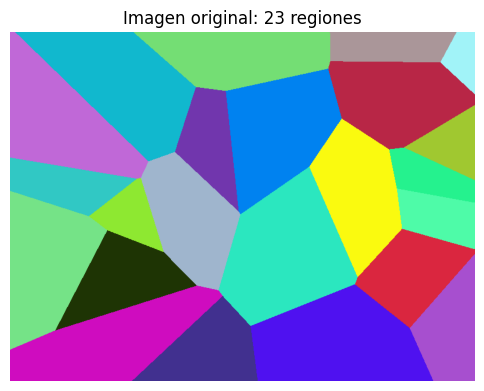

In [3]:
image = Image.open("/Users/janeth/UL/IC/23regions.png").convert("RGB")
image_np = np.array(image)

h, w, c = image_np.shape
pixels = image_np.reshape(-1, 3)

print(f"Resolución: {h}x{w}, Canales: {c}")
print(f"Total de píxeles: {pixels.shape[0]}")

plt.figure(figsize=(6, 6))
plt.imshow(image_np)
plt.axis('off')
plt.title("Imagen original: 23 regiones")
plt.show()

# 2. Define the cluster tree structure
**K-means**

The ClusterNode class represents a cluster node in the hierarchical clustering tree.

Each node stores:
* pixels_idx: the indices of pixels belonging to the cluster
* depth: the level of the node in the tree
* centroid: the average RGB color of the cluster
* left and right: child nodes if the cluster is split

This structure allows the construction of a binary tree, where each split with K-means creates two subclusters, enabling recursive and adaptive image segmentation.

In [4]:
class ClusterNode:
    def __init__(self, pixels_idx, depth):
        self.pixels_idx = pixels_idx  # Índices de los píxeles en este cluster
        self.depth = depth            # Nivel en el árbol
        self.left = None              # Subcluster 1
        self.right = None             # Subcluster 2
        self.centroid = None          # Centroide de este cluster

The function "is_homogeneous" is a stopping condition in the recursive clustering process.
It prevents unnecessary splits in areas of the image that are already uniform in color.

In [5]:
def is_homogeneous(pixels, threshold=1.0):
    if len(pixels) == 0:
        return True
    return np.var(pixels, axis=0).mean() < threshold

The split_cluster() function recursively builds a binary clustering tree by applying K-means with k = 2 to the pixels of a node.

Purpose:

To construct a hierarchical, depth-controlled, and adaptive clustering tree, where each node contains similar pixels and the image is progressively partitioned into meaningful regions.



In [6]:
def split_cluster(node, pixels, max_depth):
    if len(node.pixels_idx) == 0:
        return

    cluster_pixels = pixels[node.pixels_idx]
    node.centroid = cluster_pixels.mean(axis=0)

    # Condiciones de parada
    if node.depth >= max_depth or len(node.pixels_idx) < 2:
        print("Stopping at max depth")
        return

    if is_homogeneous(cluster_pixels, threshold=1.0):
        print("Stopping at homogeneous image at depth: "+str(node.depth))
        return

    # Intentar dividir
    kmeans = KMeans(n_clusters=2, n_init='auto', random_state=0).fit(cluster_pixels)
    labels = kmeans.labels_

    idx_left = node.pixels_idx[labels == 0]
    idx_right = node.pixels_idx[labels == 1]

    node.left = ClusterNode(idx_left, node.depth + 1)
    node.right = ClusterNode(idx_right, node.depth + 1)

    split_cluster(node.left, pixels, max_depth)
    split_cluster(node.right, pixels, max_depth)

# 3. Generate images per level

In [7]:
def get_clusters_by_level(root):
    levels = defaultdict(list)
    queue = [(root, 0)]
    while queue:
        node, level = queue.pop(0)
        levels[level].append(node)
        if node.left: queue.append((node.left, level + 1))
        if node.right: queue.append((node.right, level + 1))
    return levels

def generate_images(pixels, root, h, w):
    from collections import defaultdict
    import numpy as np

    levels = defaultdict(list)
    queue = [(root, 0)]

    # Agrupar nodos por nivel
    while queue:
        node, level = queue.pop(0)
        levels[level].append(node)
        if node.left:
            queue.append((node.left, level + 1))
        if node.right:
            queue.append((node.right, level + 1))

    images = []
    prev_img = np.zeros((pixels.shape[0], 3), dtype=np.uint8)

    for level in sorted(levels.keys()):
        # Copiar imagen previa
        img = prev_img.copy()
        painted = False

        for node in levels[level]:
            if node.pixels_idx.size == 0:
                continue
            if node.centroid is None:
                node.centroid = pixels[node.pixels_idx].mean(axis=0)
            
            img[node.pixels_idx] = node.centroid.astype(np.uint8)
            painted = True

        if painted:
            reshaped = img.reshape(h, w, 3)
            images.append(reshaped)
            prev_img = img  # Se actualiza la base para el siguiente nivel
        else:
            break  # Si no hubo cambio, ya no seguimos generando niveles

    return images


# 4. Run the clustering and visualize results

In [8]:
# Índices de todos los píxeles
pixels_idx = np.arange(pixels.shape[0])

# Crear raíz del árbol
root = ClusterNode(pixels_idx, depth=0)

# Cambia aquí la profundidad máxima deseada
max_depth = 10

# Ejecutar el clustering jerárquico
split_cluster(root, pixels, max_depth)
images = generate_images(pixels, root, h, w)

Stopping at homogeneous image at depth: 5
Stopping at homogeneous image at depth: 5
Stopping at homogeneous image at depth: 5
Stopping at homogeneous image at depth: 7
Stopping at homogeneous image at depth: 7
Stopping at homogeneous image at depth: 7
Stopping at homogeneous image at depth: 7
Stopping at homogeneous image at depth: 7
Stopping at homogeneous image at depth: 7
Stopping at homogeneous image at depth: 6
Stopping at homogeneous image at depth: 5
Stopping at homogeneous image at depth: 4
Stopping at homogeneous image at depth: 4
Stopping at homogeneous image at depth: 4
Stopping at homogeneous image at depth: 3
Stopping at homogeneous image at depth: 4
Stopping at homogeneous image at depth: 5
Stopping at homogeneous image at depth: 5
Stopping at homogeneous image at depth: 4
Stopping at homogeneous image at depth: 5
Stopping at homogeneous image at depth: 5
Stopping at homogeneous image at depth: 3
Stopping at homogeneous image at depth: 3


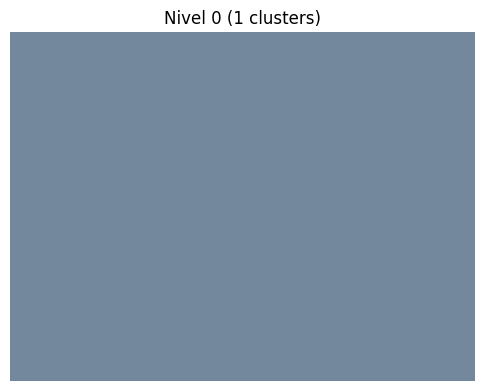

<Figure size 1200x600 with 0 Axes>

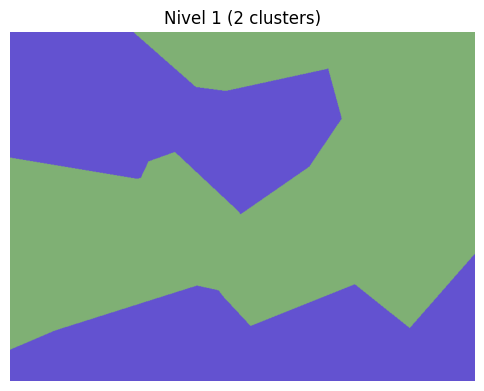

<Figure size 1200x600 with 0 Axes>

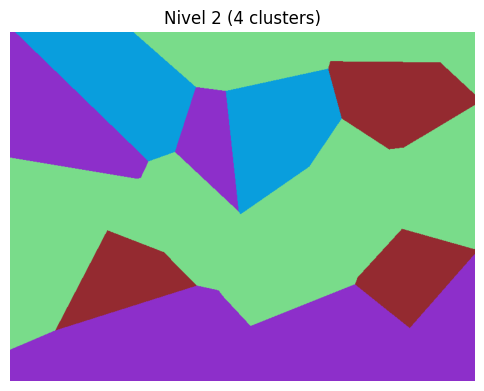

<Figure size 1200x600 with 0 Axes>

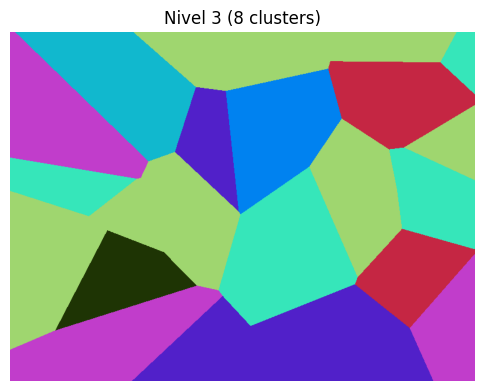

<Figure size 1200x600 with 0 Axes>

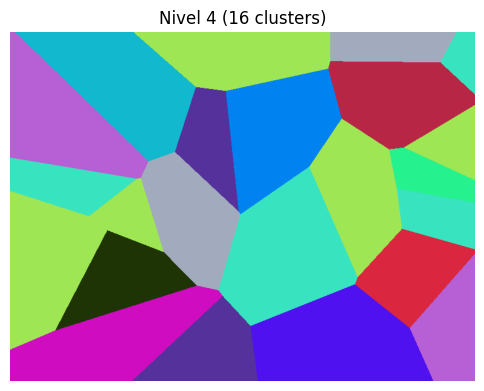

<Figure size 1200x600 with 0 Axes>

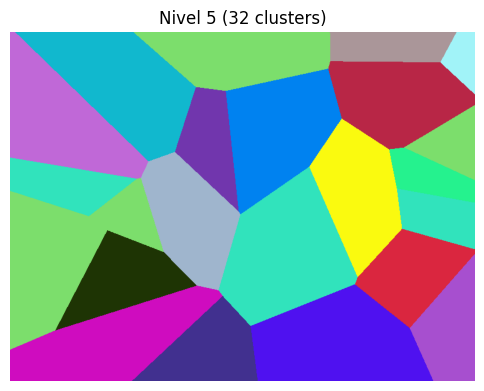

<Figure size 1200x600 with 0 Axes>

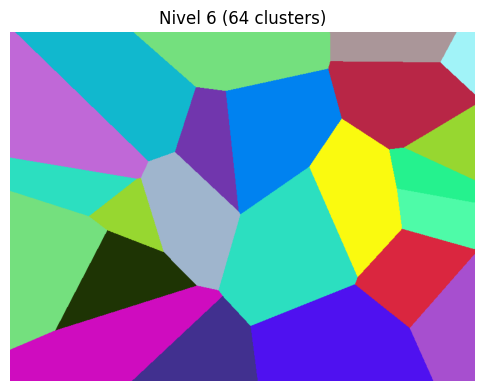

<Figure size 1200x600 with 0 Axes>

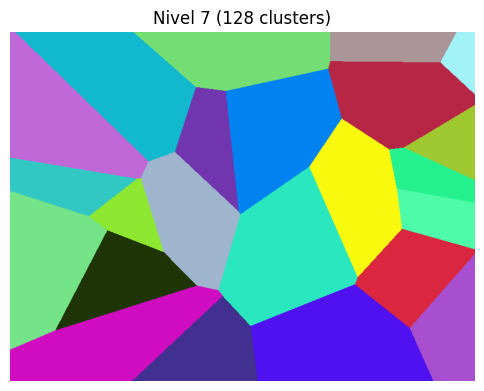

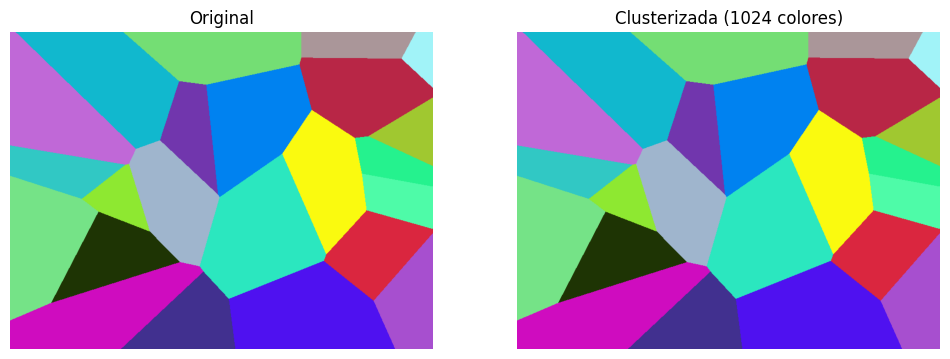

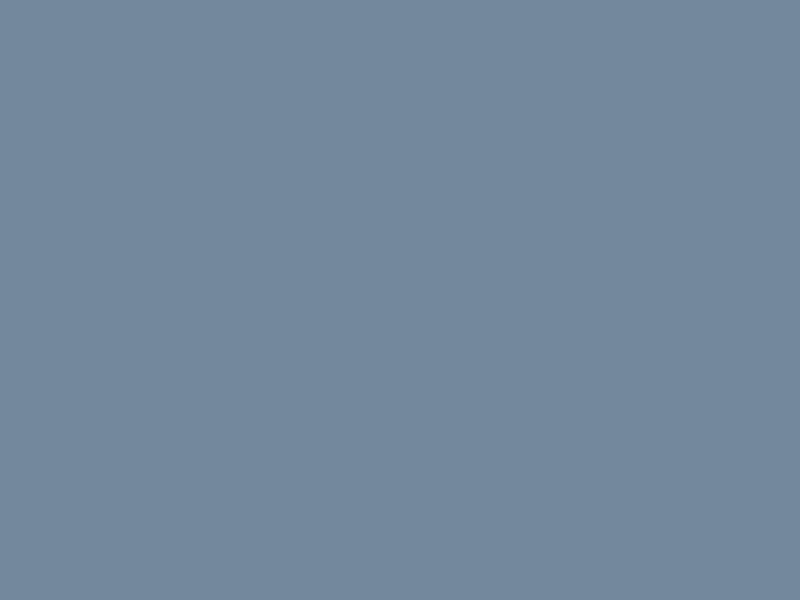

In [9]:
# Mostrar todas las imágenes generadas por nivel
for i, img in enumerate(images):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Nivel {i} ({2**i} clusters)")
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(12, 6))

# Imagen original
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original")
plt.axis("off")

# Imagen reconstruida
plt.subplot(1, 2, 2)
plt.imshow(images[-1])
plt.title(f"Clusterizada ({2**max_depth} colores)")
plt.axis("off")

plt.show()

# 1. Convertir arrays a imágenes
pil_images = [Image.fromarray(img) for img in images]

# 2. Guardar como GIF
gif_path = "cluster_evolution.gif"
pil_images[0].save(gif_path,
                   save_all=True,
                   append_images=pil_images[1:],
                   duration=500,  # milisegundos por frame
                   loop=0)

# 3. Mostrar GIF en notebook
display(IPyImage(filename=gif_path))

# 5. Print the tree structure

In [10]:
def print_cluster_tree(node, indent=""):
    if node is None:
        return

    # Info del nodo
    n_pixels = len(node.pixels_idx)
    is_leaf = node.left is None and node.right is None
    centroid = node.centroid if node.centroid is not None else "None"

    print(f"{indent} Nivel {node.depth} | Píxeles: {n_pixels} | Centroid: {centroid} | {'Hoja' if is_leaf else ''}")

    # Recurse
    if node.left:
        print(f"{indent}├─ Left")
        print_cluster_tree(node.left, indent + "│   ")
    if node.right:
        print(f"{indent}└─ Right")
        print_cluster_tree(node.right, indent + "    ")

print_cluster_tree(root)

 Nivel 0 | Píxeles: 480000 | Centroid: [115.39232708 135.26613125 157.51146875] | 
├─ Left
│    Nivel 1 | Píxeles: 267538 | Centroid: [127.93759391 176.91967122 116.8439773 ] | 
│   ├─ Left
│   │    Nivel 2 | Píxeles: 202612 | Centroid: [121.45526425 220.10662251 138.76703749] | 
│   │   ├─ Left
│   │   │    Nivel 3 | Píxeles: 129640 | Centroid: [159.16653039 214.41025147 111.88906973] | 
│   │   │   ├─ Left
│   │   │   │    Nivel 4 | Píxeles: 34675 | Centroid: [162.30967556 171.67273252 189.35426099] | 
│   │   │   │   ├─ Left
│   │   │   │   │    Nivel 5 | Píxeles: 24242 | Centroid: [159. 181. 205.] | Hoja
│   │   │   │   └─ Right
│   │   │   │        Nivel 5 | Píxeles: 10433 | Centroid: [170. 150. 153.] | Hoja
│   │   │   └─ Right
│   │   │        Nivel 4 | Píxeles: 94965 | Centroid: [158.01885958 230.01519507  83.60385405] | 
│   │   │       ├─ Left
│   │   │       │    Nivel 5 | Píxeles: 25461 | Centroid: [250. 250.  15.] | Hoja
│   │   │       └─ Right
│   │   │            Nivel 